# Improve inverse design: Active learning

To improve the inverse design quality, a possibility is to make the network learn *from its own mistakes*. 
To this end, we generate new designs using the neural network for inverse design. We re-simulate the true physical responses of these designs and perform a fine-tuning training step with these new data.

This can help especially if the network is trained on a generic dataset (e.g. based on random designs).
Finetuning the network specifically oin the inverse design task can significantly improve its performance.

We will specifically optimize the forward network for minimzation and maximization of the reflectivity at a specific wavelength.

## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import nevergrad as ng
from concurrent import futures

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-07-13 16:16:20.625132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 16:16:21.178957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-13 16:16:22.470615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 16:16:22.495151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Load the dataset

We use only the validation set to get a rough estimate of training convergence.
Ideally we would generate a new validation set along with the new fine-tuning data, but for sake of execution time we will simply use the original data for validation.

In [2]:
data_path = 'datasets/dataset1_random.h5'

# load data and scalers
x_train, x_test, y_train, y_test = helper.load_reflection_spectra_data(data_path)
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))

wavelengths = np.linspace(500, 1500, 64)

## load pre-trained forward model

We demonstrate active learning with forward model based, iterative inverse design. Of course this can be done with end-to-end inverse design models as well, for example with the Tandem model. In this case, the generator will be used to predict inverse designs to random design targets, these designs are re-calculated and added to the dataset. The networks are trained on the extended dataset and the generation process is repeated. In case of the Tandem there are two training steps. First the forward network is fine-trained, then the full Tandem training is continued on the extended data, using the improved forward net and the former generator.

Here we use only the forward netwokr with global optimization (GO), since GO provides automatically a relatively rich variety in its optimization results.

In [3]:
fwd_path = 'models/fwd_model_resnet.h5'

# load pretrained forward model
fwd_model = keras.models.load_model(fwd_path)

2023-07-13 16:16:23.240944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 16:16:23.241125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 16:16:23.241244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Define global optimization helper

We define a first helper that optimizes layer-stacks using the forward network, with the goal to minimize or maximize reflectivity at a specific wavelength.

We define a second function that performs many of these optimizations and gathers all final designs

In [4]:
def get_new_data_based_on_invdesign(N_population, target_wl, N_func_eval=500, maximize_R=True, param_limit=3):
    # index of wavelength at which to min/maximize R
    maximize_wl_index = np.argmin(np.abs(wavelengths - target_wl))

    # define optimization target: MSE between reflectivities
    def fitness_func(geo, maximize_wl_index):
        # MSE between target and NN-predicted spectrum
        pred_spec = fwd_model.predict(geo, verbose=0)[0]
        if maximize_R:
            return -1 * np.squeeze(pred_spec[maximize_wl_index])  # factor -1: maximize R
        else:
            return np.squeeze(pred_spec[maximize_wl_index])  # minimize R

    # setup the nevergrad paramterization:
    args_geo_ng = ng.p.Array(
        shape=[1, *fwd_model.input_shape[1:]],
        lower=-param_limit, upper=param_limit
    )

    # wrap optimized and fixed arguments together
    instru = ng.p.Instrumentation(
        geo=args_geo_ng,     # optimization args (geometry)
        maximize_wl_index=maximize_wl_index,  # additional (fixed) arg (design target spectrum)
    )

    # =============================================================================
    # run optimization
    # =============================================================================
    optim_algo = ng.families.DifferentialEvolution(crossover="twopoints", popsize=N_population)
    NG_optimizer = optim_algo(instru, budget=N_func_eval, num_workers=8)

    with futures.ThreadPoolExecutor(max_workers=8) as executor:
        x_opt = NG_optimizer.minimize(fitness_func, executor=executor, verbosity=0)

    pop = NG_optimizer.population


    # =============================================================================
    # get final population
    # =============================================================================
    # extract all designs in the pre-optimized population
    geo_gloopt = []
    for k in pop:
        geo_design = np.array(pop[k][1]['geo'].value)
        geo_gloopt.append(geo_design[0])
    geos_gloopt = np.array(geo_gloopt)

    # recalculate with pymoosh
    mat_physical = scaler_mat.inverse_transform(geos_gloopt[..., 0])
    thick_physical = scaler_thick.inverse_transform(geos_gloopt[..., 1])
    y_recalc = helper.batch_calc_R(thick_physical, mat_physical, wavelengths, verbose=0)

    # return results in dataset compatible format (normalized)
    return geos_gloopt, y_recalc


# helper that calls optimization multiple times
def generate_finetune_dataset(N_design_targets, N_population, N_func_eval, param_constraint):
    x_active = []
    y_active = []
    y_predict = []
    for i_tg in range(N_design_targets):
        target_wl = np.random.randint(500, 15000)
        maximize = np.random.choice([False, True])
        x_new, y_new = get_new_data_based_on_invdesign(
            N_population, target_wl, N_func_eval=N_func_eval, 
            maximize_R=maximize, param_limit=param_constraint)
        y_pred = fwd_model.predict(x_new, verbose=0)
        
        x_active.append(x_new)
        y_active.append(y_new)
        y_predict.append(y_pred)
    return np.concatenate(x_active), np.concatenate(y_active), np.concatenate(y_predict)


## Test the helper on a mini-optimization

/home/pwiecha/.local/lib/python3.10/site-packages/nevergrad/optimization/differentialevolution.py:109: InefficientSettingsWarning: DE algorithms are inefficient with budget < 60
  warnings.warn(
2023-07-13 16:16:25.577772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-13 16:16:26.386482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
6it [00:00, 107.89it/s]

1/1 [==============================] - 0s 69ms/step


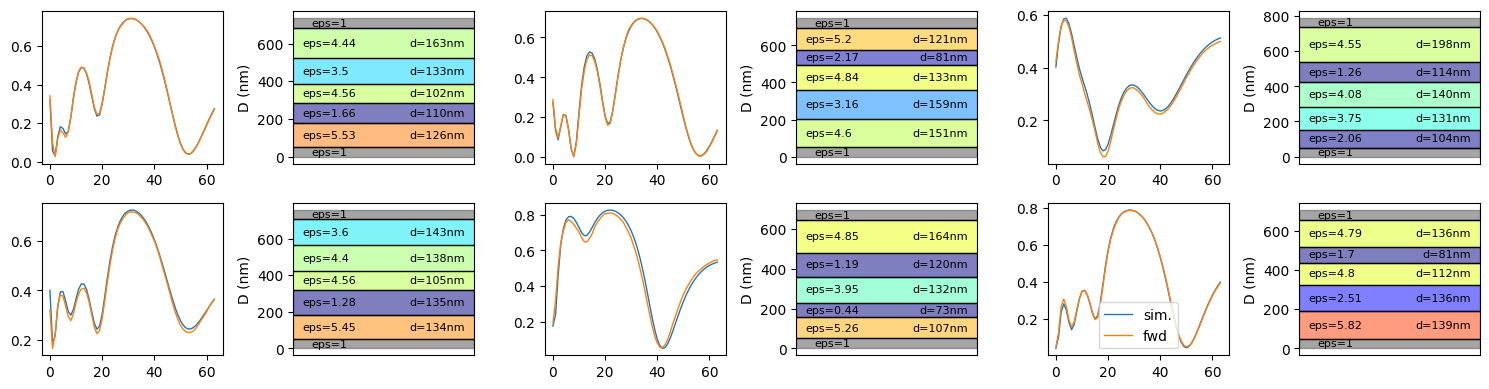

In [5]:
target_wl = 1000
N_population = 6
N_func_eval = 50
maximize = True
param_constraint = 3  # deliberately allow some weak extrapolation

# maximize reflection at 1000nm
x_new, y_new = get_new_data_based_on_invdesign(
    N_population, target_wl, N_func_eval=N_func_eval, maximize_R=maximize, param_limit=param_constraint)

# predict and plot predictions vs pymoosh
y_pred = fwd_model.predict(x_new)

helper.plot_benchmark_R_samples(y_new, y_pred,
                                random_order=False, plot_design=True,
                                N_plot=(2, 3),
                                y_designs=x_new,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['sim.', 'fwd'])

In [6]:
N_iter_train = 5
N_design_targets = 25
param_constraint = 3  # deliberately allow some weak extrapolation

N_population = 30
N_func_eval = 90

# the actual retraining loop
all_x = []
all_y = []
all_error_stats = []
for i_train in range(N_iter_train):
    print("="*60)
    print("training loop {}/{}:".format(
        i_train, N_iter_train))
    print("="*60)
    
    # generate new samples for min / max single wavelength task
    print("creating {} new samples and re-train...".format(
        N_design_targets*N_population))
    x_active, y_active, y_act_pred = generate_finetune_dataset(
        N_design_targets, N_population, N_func_eval, param_constraint)
    
    # keep all generated samples
    all_x.append(x_active)
    all_y.append(y_active)
    
    # calc. error on new data for benchmark
    err = np.squeeze(y_act_pred) - np.squeeze(y_active)
    err_max = np.max(np.abs(err), axis=-1)
    all_error_stats.append(err_max)

    # compile fwd net with optimizer and loss and train
    fwd_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.00005),
                      loss='mse')

    print('finetune fwd net on new data...')
    history = fwd_model.fit(x=np.concatenate(all_x), y=np.concatenate(all_y),
                            validation_data=(x_test, y_test),
                            batch_size=128, epochs=50, verbose=1)




training loop 0/5:
creating 750 new samples and re-train...


30it [00:00, 93.46it/s]
30it [00:00, 94.48it/s]
30it [00:00, 107.61it/s]
30it [00:00, 96.15it/s]
30it [00:00, 92.35it/s]
30it [00:00, 93.26it/s]
30it [00:00, 107.97it/s]
30it [00:00, 105.65it/s]
30it [00:00, 93.54it/s]
30it [00:00, 108.21it/s]
30it [00:00, 93.44it/s]
30it [00:00, 93.10it/s]
30it [00:00, 94.38it/s]
30it [00:00, 94.35it/s]
30it [00:00, 94.01it/s]
30it [00:00, 97.98it/s]
30it [00:00, 105.69it/s]
30it [00:00, 92.79it/s]
30it [00:00, 93.93it/s]
30it [00:00, 106.83it/s]
30it [00:00, 107.51it/s]
30it [00:00, 106.56it/s]
30it [00:00, 106.00it/s]
30it [00:00, 92.39it/s]
30it [00:00, 106.42it/s]


finetune fwd net on new data...
Epoch 1/50


2023-07-13 16:17:57.763091: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f72042d6140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-13 16:17:57.763118: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-13 16:17:57.769006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-13 16:17:57.928888: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - 16s 301ms/step - loss: 0.0032 - val_loss: 4.4612e-04
Epoch 2/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0025 - val_loss: 3.4796e-04
Epoch 3/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0021 - val_loss: 3.1483e-04
Epoch 4/50
6/6 [==============================] - 0s 83ms/step - loss: 0.0018 - val_loss: 3.2284e-04
Epoch 5/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0016 - val_loss: 3.3000e-04
Epoch 6/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0014 - val_loss: 2.8907e-04
Epoch 7/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0013 - val_loss: 2.8494e-04
Epoch 8/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0011 - val_loss: 2.6127e-04
Epoch 9/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0010 - val_loss: 2.5985e-04
Epoch 10/50
6/6 [==============================] - 0s 58ms/step - loss: 9.4969e-04 - val_loss: 2.492

30it [00:00, 94.57it/s]
30it [00:00, 107.15it/s]
30it [00:00, 107.05it/s]
30it [00:00, 108.17it/s]
30it [00:00, 93.53it/s]
30it [00:00, 107.76it/s]
30it [00:00, 93.32it/s]
30it [00:00, 107.19it/s]
30it [00:00, 106.85it/s]
30it [00:00, 108.15it/s]
30it [00:00, 107.00it/s]
30it [00:00, 92.85it/s]
30it [00:00, 93.92it/s]
30it [00:00, 107.68it/s]
30it [00:00, 106.32it/s]
30it [00:00, 98.71it/s]
30it [00:00, 104.88it/s]
30it [00:00, 107.98it/s]
30it [00:00, 92.62it/s]
30it [00:00, 92.66it/s]
30it [00:00, 94.65it/s]
30it [00:00, 106.93it/s]
30it [00:00, 98.93it/s]
30it [00:00, 107.61it/s]
30it [00:00, 93.05it/s]

finetune fwd net on new data...
Epoch 1/50


12/12 [==============================] - 14s 123ms/step - loss: 9.4079e-04 - val_loss: 1.7643e-04
Epoch 2/50
12/12 [==============================] - 1s 48ms/step - loss: 7.3243e-04 - val_loss: 1.6919e-04
Epoch 3/50
12/12 [==============================] - 0s 42ms/step - loss: 6.2586e-04 - val_loss: 1.7121e-04
Epoch 4/50
12/12 [==============================] - 1s 44ms/step - loss: 5.4799e-04 - val_loss: 1.6452e-04
Epoch 5/50
12/12 [==============================] - 1s 43ms/step - loss: 4.8983e-04 - val_loss: 1.5764e-04
Epoch 6/50
12/12 [==============================] - 1s 43ms/step - loss: 4.3998e-04 - val_loss: 1.5427e-04
Epoch 7/50
12/12 [==============================] - 0s 42ms/step - loss: 3.9745e-04 - val_loss: 1.5332e-04
Epoch 8/50
12/12 [==============================] - 1s 43ms/step - loss: 3.6446e-04 - val_loss: 1.5242e-04
Epoch 9/50
12/12 [==============================] - 0s 42ms/step - loss: 3.3830e-04 - val_loss: 1.4970e-04
Epoch 10/50
12/12 [===========================

30it [00:00, 91.79it/s]
30it [00:00, 107.49it/s]
30it [00:00, 105.43it/s]
30it [00:00, 103.23it/s]
30it [00:00, 93.60it/s]
30it [00:00, 91.88it/s]
30it [00:00, 95.42it/s]
30it [00:00, 105.56it/s]
30it [00:00, 94.35it/s]
30it [00:00, 106.95it/s]
30it [00:00, 106.34it/s]
30it [00:00, 95.12it/s]
30it [00:00, 105.92it/s]
30it [00:00, 92.96it/s]
30it [00:00, 94.23it/s]
30it [00:00, 105.05it/s]
30it [00:00, 103.63it/s]
30it [00:00, 95.79it/s]
30it [00:00, 92.55it/s]
30it [00:00, 106.36it/s]
30it [00:00, 105.66it/s]
30it [00:00, 94.34it/s]
30it [00:00, 95.60it/s]
30it [00:00, 90.62it/s]
30it [00:00, 93.33it/s]


finetune fwd net on new data...
Epoch 1/50
18/18 [==============================] - 14s 89ms/step - loss: 3.8739e-04 - val_loss: 1.2922e-04
Epoch 2/50
18/18 [==============================] - 1s 39ms/step - loss: 3.0862e-04 - val_loss: 1.2493e-04
Epoch 3/50
18/18 [==============================] - 1s 40ms/step - loss: 2.6797e-04 - val_loss: 1.3223e-04
Epoch 4/50
18/18 [==============================] - 1s 40ms/step - loss: 2.3948e-04 - val_loss: 1.2493e-04
Epoch 5/50
18/18 [==============================] - 1s 39ms/step - loss: 2.1422e-04 - val_loss: 1.1920e-04
Epoch 6/50
18/18 [==============================] - 1s 39ms/step - loss: 1.9123e-04 - val_loss: 1.2204e-04
Epoch 7/50
18/18 [==============================] - 1s 39ms/step - loss: 1.7630e-04 - val_loss: 1.1695e-04
Epoch 8/50
18/18 [==============================] - 1s 39ms/step - loss: 1.6165e-04 - val_loss: 1.1532e-04
Epoch 9/50
18/18 [==============================] - 1s 40ms/step - loss: 1.4909e-04 - val_loss: 1.1604e-04
Epoc

30it [00:00, 106.13it/s]
30it [00:00, 95.17it/s]
30it [00:00, 106.99it/s]
30it [00:00, 97.28it/s] 
30it [00:00, 106.35it/s]
30it [00:00, 93.16it/s]
30it [00:00, 91.31it/s]
30it [00:00, 92.38it/s]
30it [00:00, 105.35it/s]
30it [00:00, 92.85it/s]
30it [00:00, 97.31it/s]
30it [00:00, 104.90it/s]
30it [00:00, 107.09it/s]
30it [00:00, 106.09it/s]
30it [00:00, 103.69it/s]
30it [00:00, 93.74it/s]
30it [00:00, 96.70it/s]
30it [00:00, 103.91it/s]
30it [00:00, 107.01it/s]
30it [00:00, 92.80it/s]
30it [00:00, 104.40it/s]
30it [00:00, 98.10it/s]
30it [00:00, 95.64it/s]
30it [00:00, 94.85it/s]
30it [00:00, 94.45it/s]


finetune fwd net on new data...
Epoch 1/50
24/24 [==============================] - 14s 75ms/step - loss: 2.8053e-04 - val_loss: 1.1183e-04
Epoch 2/50
24/24 [==============================] - 1s 36ms/step - loss: 2.0849e-04 - val_loss: 1.0655e-04
Epoch 3/50
24/24 [==============================] - 1s 40ms/step - loss: 1.7215e-04 - val_loss: 1.0554e-04
Epoch 4/50
24/24 [==============================] - 1s 37ms/step - loss: 1.5289e-04 - val_loss: 1.0675e-04
Epoch 5/50
24/24 [==============================] - 1s 37ms/step - loss: 1.3492e-04 - val_loss: 1.0799e-04
Epoch 6/50
24/24 [==============================] - 1s 36ms/step - loss: 1.2419e-04 - val_loss: 1.0567e-04
Epoch 7/50
24/24 [==============================] - 1s 37ms/step - loss: 1.1494e-04 - val_loss: 1.0394e-04
Epoch 8/50
24/24 [==============================] - 1s 38ms/step - loss: 1.0539e-04 - val_loss: 1.0456e-04
Epoch 9/50
24/24 [==============================] - 1s 37ms/step - loss: 9.7544e-05 - val_loss: 1.0455e-04
Epoc

30it [00:00, 92.05it/s]
30it [00:00, 94.52it/s]
30it [00:00, 106.86it/s]
30it [00:00, 93.11it/s]
30it [00:00, 94.00it/s]
30it [00:00, 92.44it/s]
30it [00:00, 109.34it/s]
30it [00:00, 91.60it/s]
30it [00:00, 105.95it/s]
30it [00:00, 93.42it/s]
30it [00:00, 104.63it/s]
30it [00:00, 91.96it/s]
30it [00:00, 93.42it/s]
30it [00:00, 105.98it/s]
30it [00:00, 95.12it/s]
30it [00:00, 96.52it/s] 
30it [00:00, 106.36it/s]
30it [00:00, 91.76it/s]
30it [00:00, 95.85it/s]
30it [00:00, 106.07it/s]
30it [00:00, 107.91it/s]
30it [00:00, 108.07it/s]
30it [00:00, 92.51it/s]
30it [00:00, 92.30it/s]
30it [00:00, 93.50it/s]


finetune fwd net on new data...
Epoch 1/50
30/30 [==============================] - 14s 62ms/step - loss: 2.3845e-04 - val_loss: 1.1150e-04
Epoch 2/50
30/30 [==============================] - 1s 36ms/step - loss: 1.7868e-04 - val_loss: 1.0123e-04
Epoch 3/50
30/30 [==============================] - 1s 35ms/step - loss: 1.5285e-04 - val_loss: 9.8930e-05
Epoch 4/50
30/30 [==============================] - 1s 36ms/step - loss: 1.2715e-04 - val_loss: 1.0065e-04
Epoch 5/50
30/30 [==============================] - 1s 36ms/step - loss: 1.1988e-04 - val_loss: 9.9278e-05
Epoch 6/50
30/30 [==============================] - 1s 36ms/step - loss: 1.0492e-04 - val_loss: 1.0060e-04
Epoch 7/50
30/30 [==============================] - 1s 36ms/step - loss: 9.5136e-05 - val_loss: 9.9316e-05
Epoch 8/50
30/30 [==============================] - 1s 36ms/step - loss: 8.8923e-05 - val_loss: 1.0038e-04
Epoch 9/50
30/30 [==============================] - 1s 36ms/step - loss: 8.3012e-05 - val_loss: 9.7281e-05
Epoc

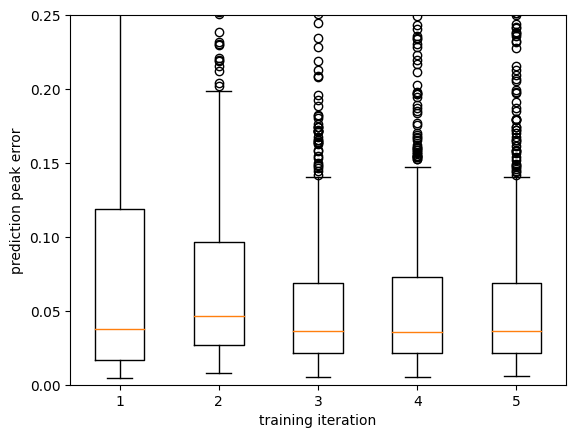

In [7]:
# boxplot for error in each iteration
box_data = plt.boxplot(all_error_stats)

plt.xlabel('training iteration')
plt.ylabel('prediction peak error')

plt.ylim(0, 0.25)
plt.show()